# Problem 4 (CIFAR with PyTorch)

> Reference:
- https://github.com/aaron-xichen/pytorch-playground
- https://github.com/icpm/pytorch-cifar10
- https://github.com/Lornatang/pytorch-alexnet-cifar100

In [1]:
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# Process data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load Train data and split into train set and valid set
num_train = 50000
indices = list(range(num_train))
train_index, valid_index = indices[10000:], indices[:10000]
train_sampler=SubsetRandomSampler(train_index)
valid_sampler=SubsetRandomSampler(valid_index)
train_dataset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                        download=False, transform=transform)
valid_dataset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                        download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, 
               batch_size=32, sampler=train_sampler, 
               num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=10, sampler=valid_sampler, 
               num_workers=4, pin_memory=True)

# Load test data
testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False,
                                       download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, 
              batch_size=10,pin_memory=True,
              shuffle=True, num_workers=4)

# Define Class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
# Save data in list for plot    
save_train_loss=[]
save_valid_loss=[]
save_test_loss=[]
save_train_acc=[]
save_valid_acc=[]
save_test_acc=[]

In [27]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [28]:
def plot_images(images,labels = None):
    figure = plt.figure(figsize=(10,10))
    for i in range(len(images)):
        unnormalized_image = images[i]*0.5 + 0.5
        ax = plt.subplot(1,len(images),i+1)
        plt.imshow(unnormalized_image)
        plt.axis('off')
        if labels is not None:
            plt.title(classes[labels[i]])

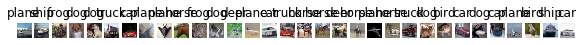

In [29]:
sample = next(iter(train_loader))
image, label = sample
plot_images(np.transpose(image.numpy(),(0,2,3,1)), label.numpy())

In [4]:
def main(iteration = 10, gpu_usage = False, opti = 'default', 
         Xavier = False, batch_norm = False):
    # detect GPU
    if gpu_usage:
        use_cuda  = torch.cuda.is_available()
    else:
        use_cuda = False
    # define network
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            if batch_norm:
                # batch normalization
                self.conv1 = nn.Conv2d(3, 96, 3, stride=1, padding=1)
                self.conv1_bn = nn.BatchNorm2d(96)
                self.pool1 = nn.MaxPool2d(2, 2)
                self.conv2 = nn.Conv2d(96, 256, 3, stride=1, padding=1)
                self.conv2_bn = nn.BatchNorm2d(256)
                self.pool2 = nn.MaxPool2d(2, 2)
                self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding=1)
                self.conv3_bn = nn.BatchNorm2d(384)
                self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding=1)
                self.conv4_bn = nn.BatchNorm2d(384)
                self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding=1)
                self.conv5_bn = nn.BatchNorm2d(256)
                self.pool5 = nn.MaxPool2d(2, 2)
                self.fc1 = nn.Linear(256 * 4 * 4, 4096)
                self.drop1 = nn.Dropout2d(0.2)
                self.fc2 = nn.Linear(4096, 4096)
                self.drop2 = nn.Dropout2d(0.2)
                self.fc3 = nn.Linear(4096, 10)
            else:
                # no batch normalization
                self.conv1 = nn.Conv2d(3, 96, 3, stride=1, padding=1)
                self.pool1 = nn.MaxPool2d(2, 2)
                self.conv2 = nn.Conv2d(96, 256, 3, stride=1, padding=1)
                self.pool2 = nn.MaxPool2d(2, 2)
                self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding=1)
                self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding=1)
                self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding=1)
                self.pool5 = nn.MaxPool2d(2, 2)
                self.fc1 = nn.Linear(256 * 4 * 4, 4096)
                self.drop1 = nn.Dropout2d(0.2)
                self.fc2 = nn.Linear(4096, 4096)
                self.drop2 = nn.Dropout2d(0.2)
                self.fc3 = nn.Linear(4096, 10)

            # Xavier init, need to check formula
            # Xavier Initialize for the whole network
            if Xavier:
                for m in self.modules():
                    if isinstance(m, nn.Conv2d):
                        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                        m.weight.data.normal_(0, math.sqrt(2. / n))
                    elif isinstance(m, nn.BatchNorm2d):
                        m.weight.data.fill_(1)
                        m.bias.data.zero_()
                        
        def forward(self, x):
            if batch_norm:
                # batch normalization
                x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
                x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
                x = F.relu(self.conv3_bn(self.conv3(x)))
                x = F.relu(self.conv4_bn(self.conv4(x)))
                x = self.pool5(F.relu(self.conv5_bn(self.conv5(x))))
                x = x.view(-1, 256 * 4 * 4)
                x = self.drop1(F.relu(self.fc1(x)))
                x = self.drop2(F.relu(self.fc2(x)))
                x = self.fc3(x)
            else:
                # no batch normalization
                x = self.pool1(F.relu(self.conv1(x)))
                x = self.pool2(F.relu(self.conv2(x)))
                x = F.relu(self.conv3(x))
                x = F.relu(self.conv4(x))
                x = self.pool5(F.relu(self.conv5(x)))
                x = x.view(-1, 256 * 4 * 4)
                x = self.drop1(F.relu(self.fc1(x)))
                x = self.drop2(F.relu(self.fc2(x)))
                x = self.fc3(x)
            return x

    net = Net()
#   net.apply(weights_init)
    
    ## using GPU
    if use_cuda:
        net.cuda()
        net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
        cudnn.benchmark = True

    ## loss function
    criterion = nn.CrossEntropyLoss()
    if (opti == "Adam"):
        optimizer = optim.Adam(net.parameters(), lr = 0.001)
    else:
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)

    ## starting training testinig validating
    start = timeit.default_timer()
    print('epoch, mini-batch\ttrain_loss\tvalid_loss\ttest_loss\ttrain_acc\tvalid_acc\ttest_acc')
    for epoch in range(iteration):  # loop over the dataset multiple times
        train_running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            # detect GPU
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_running_loss += loss.item()
            
            if i % 501 == 500:    # print every 1 mini-batches
                train_loss = train_running_loss / 500
                #print('train_loss = '+str(train_loss))
                train_running_loss = 0.0            
                # Train
                correct = 0
                total = 0
                for data in train_loader:
                    images, labels = data
                    # detect GPU
                    if use_cuda:
                        images, labels = images.cuda(), labels.cuda()
                    outputs = net(Variable(images))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                train_acc = 100 * correct / total
                #print('train_acc = '+str(train_acc))
                # Valid
                correct = 0
                total = 0
                valid_loss = 0
                for data in valid_loader:
                    images, labels = data
                    # detect GPU
                    if use_cuda:
                        images, labels = images.cuda(), labels.cuda()
                    v_images, v_labels = Variable(images), Variable(labels)
                    outputs = net(v_images)
                    valid_loss += criterion(outputs, v_labels).item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                valid_loss /= 1000
                valid_acc = 100 * correct / total
                # Test
                correct = 0
                total = 0
                test_loss = 0
                for data in test_loader:
                    images, labels = data
                    # detect GPU
                    if use_cuda:
                        images, labels = images.cuda(), labels.cuda()
                    v_images, v_labels = Variable(images), Variable(labels)
                    outputs = net(v_images)
                    test_loss += criterion(outputs, v_labels).item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                test_loss /= 1000
                test_acc = 100 * correct / total
                # Save data for plot
                save_train_loss.append(train_loss)
                save_valid_loss.append(valid_loss)
                save_test_loss.append(test_loss)
                save_train_acc.append(train_acc)
                save_valid_acc.append(valid_acc)
                save_test_acc.append(test_acc)
                print('[%d, %5d]\t\t%.3f\t\t%.3f\t\t%.3f\t\t%.3f%%\t\t%.3f%%\t\t%.3f%%'%(epoch + 1, i + 1, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc))
    print('Finished Training')
    stop = timeit.default_timer()
    print ('Time it takes: %.3f second' %(stop - start))



In [5]:
# iteration: howmany iteration you want. default = 10
# gpu_usage: use GPU or not. default = false
# opti: type of optimizer. default: SGD
main(iteration = 100, gpu_usage = True, opti = 'SGD', Xavier = True, batch_norm = True)

epoch, mini-batch	train_loss	valid_loss	test_loss	train_acc	valid_acc	test_acc
[1,   501]		1.536		1.332		1.335		54.000%		51.000%		52.000%
[1,  1002]		1.198		1.173		1.185		61.000%		57.000%		57.000%
[2,   501]		0.949		1.014		1.029		68.000%		64.000%		64.000%
[2,  1002]		0.884		0.922		0.948		72.000%		68.000%		67.000%
[3,   501]		0.729		0.972		0.963		72.000%		67.000%		67.000%
[3,  1002]		0.717		0.793		0.815		78.000%		73.000%		72.000%
[4,   501]		0.591		0.826		0.842		80.000%		73.000%		73.000%
[4,  1002]		0.605		0.710		0.716		83.000%		75.000%		76.000%
[5,   501]		0.476		0.702		0.731		85.000%		76.000%		76.000%
[5,  1002]		0.486		0.717		0.728		85.000%		76.000%		76.000%
[6,   501]		0.376		0.686		0.702		88.000%		77.000%		77.000%
[6,  1002]		0.408		0.702		0.711		88.000%		77.000%		76.000%
[7,   501]		0.299		0.703		0.712		90.000%		78.000%		78.000%
[7,  1002]		0.317		0.701		0.713		91.000%		78.000%		78.000%
[8,   501]		0.231		0.697		0.733		92.000%		79.000%		78.000%
[8,  1002]		0.259		0.695		0.710		93.

[69,   501]		0.005		1.042		1.104		99.000%		83.000%		83.000%
[69,  1002]		0.007		1.113		1.129		99.000%		82.000%		82.000%
[70,   501]		0.004		1.068		1.095		99.000%		83.000%		82.000%
[70,  1002]		0.003		1.087		1.132		99.000%		82.000%		82.000%
[71,   501]		0.003		1.114		1.160		99.000%		82.000%		82.000%
[71,  1002]		0.005		1.124		1.191		99.000%		82.000%		82.000%
[72,   501]		0.007		1.124		1.143		99.000%		82.000%		82.000%
[72,  1002]		0.006		1.070		1.109		99.000%		83.000%		83.000%
[73,   501]		0.002		1.096		1.148		99.000%		82.000%		83.000%
[73,  1002]		0.003		1.106		1.155		99.000%		83.000%		83.000%
[74,   501]		0.004		1.097		1.126		99.000%		83.000%		82.000%
[74,  1002]		0.002		1.089		1.118		99.000%		82.000%		83.000%
[75,   501]		0.001		1.119		1.148		99.000%		83.000%		83.000%
[75,  1002]		0.002		1.137		1.163		99.000%		82.000%		82.000%
[76,   501]		0.001		1.107		1.140		99.000%		83.000%		83.000%
[76,  1002]		0.000		1.122		1.127		99.000%		82.000%		83.000%
[77,   501]		0.001		1.149		1.200		99.000

In [6]:
def plot_accuracy(trainacc,validacc,testacc):
    plt.figure()
    plt.title('AlexNet\nAccuracy vs epoch')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.plot(trainacc,'red')
    plt.plot(validacc,'blue')
    plt.plot(testacc,'green')
    plt.legend(['train','valid','test'])
    plt.grid(True)
    plt.savefig('HW3_accuracy_model_3_32_batch_001.png')
    plt.show()

def plot_loss(trainloss,validloss,testloss):
    plt.figure()
    plt.title('AlexNet\nLoss vs epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(trainloss,'red')
    plt.plot(validloss,'blue')
    plt.plot(testloss,'green')
    plt.legend(['train','valid','test'])
    plt.grid(True)
    plt.savefig('HW3_loss_model_3_32_batch_001.png')
    plt.show()

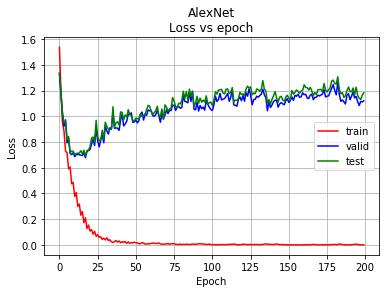

In [7]:
plot_loss(save_train_loss,save_valid_loss,save_test_loss)

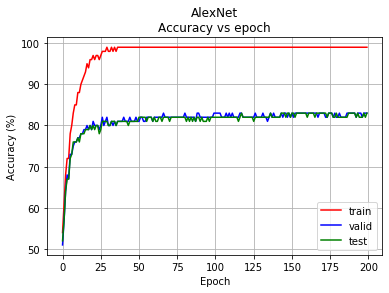

In [8]:
plot_accuracy(save_train_acc,save_valid_acc,save_test_acc)

- AlexNet is used for the main CNN template for further modification and optimization on NN architecture with other optimization methods being implemented for the training process improvement.
- Due to the limitation of computing resources, only 32 dataset is randomly selected as one mini-batch for the training process. When I increase the batchsize, the computing time is getting jumped even though I run the code on the datahub with GPU. Also, the final code which is optimized is also using hugh resources on datahub, i.e., upto 18650MB/93GPU/120CPU.
- After training for 5000 mini-batches with learning rate of 0.001, the performance data is extracted for the comparison report.
- Finally, the results of different speed-up methods are summarized in the table below.
- The selected model, AlexNet, which is also slightly modified, reaches the accruacy of 82% for the test dataset 

|Optimization method|Entorpy(Train)|Entropy(Valid)|Entropy(Test)|Accuracy(Train)|Accuracy(Valid)|Accuracy(Test)|
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|SGD|0.484|0.714|0.729|88.71|75.91|75.92|
|Batch Normalization|0.485|0.680|0.726|86.93|77.82|77.13|
|Average Pooling|0.472|0.717|0.720|86.08|75.76|76.00|
|Adaptive Gradient|0.362|0.774|0.783|89.04|74.19|73.80|
|Nesterov's Accelerate|0.459|0.738|0.728|88.22|75.38|76.13|
|RMSprop|0.446|0.702|0.727|87.127|76.52|75.88|

- Architecture of AlexNet model to be used

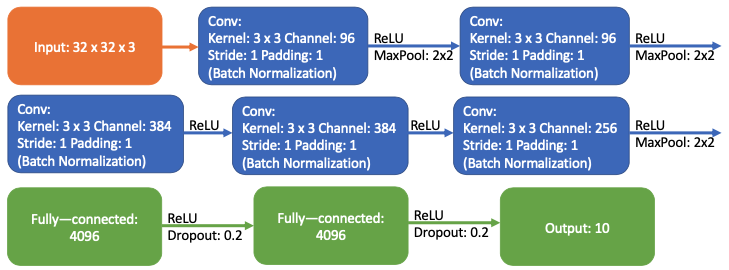